# Using Jurassic-1 Large on SageMaker through Model Packages

This sample notebook shows you how to deploy Jurassic-1 Large using Amazon SageMaker.

> **Note**: This is a reference notebook and it cannot run unless you make changes suggested in the notebook.

## Pre-requisites:
1. Before running this notebook, please make sure you got this notebook from the model catalog on SageMaker AWS Management Console.
1. **Note**: This notebook contains elements which render correctly in Jupyter interface. Open this notebook from an Amazon SageMaker Notebook Instance or Amazon SageMaker Studio.
1. Ensure that IAM role used has **AmazonSageMakerFullAccess**.
1. This noebook is intended to work with **boto3 v1.25.4** or higher.

## Contents:
1. [Select model package](#1.-Subscribe-to-the-model-package)
2. [Create an endpoint and perform real-time inference](#2.-Create-an-endpoint-and-perform-real-time-inference)
   1. [Create an endpoint](#A.-Create-an-endpoint)
   2. [Create input payload](#B.-Create-an-input-prompt)
   3. [Perform real-time inference](#C.-Perform-real-time-inference)
   4. [Create the dashboard](#D.-Create-the-dashboard)
   5. [Delete the endpoint](#E.-Delete-the-endpoint)
3. [Clean-up](#4.-Clean-up)
    1. [Delete the model](#A.-Delete-the-model)
    

## Usage instructions
You can run this notebook one cell at a time (By using Shift+Enter for running a cell).

## 1. Select to the model package
Confirm that you recieved this notebook from model catalog on SageMaker AWS Management Console.


In [1]:
# Mapping for Model Packages (initially only us-east-1 and eu-west-1 is supported)
model_package_map = {
    "us-east-1": "arn:aws:sagemaker:us-east-1:416407187090:model-package/j1-large-dbf0249",
#     "eu-west-1": "",
}

In [2]:
# SageMaker imports
import json
from sagemaker import ModelPackage
from sagemaker import get_execution_role
from sagemaker import ModelPackage
import sagemaker as sage
import boto3

# Use-case imports
from tqdm import tqdm
from utils_lib.utils import *

In [3]:
! pip install -U ai21-python-client[SM]
import ai21

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p38/bin/python -m pip install --upgrade pip' command.


In [4]:
region = boto3.Session().region_name
if region not in model_package_map.keys():
    raise ("UNSUPPORTED REGION")

model_package_arn = model_package_map[region]

In [5]:
role = get_execution_role()
sagemaker_session = sage.Session()

runtime_sm_client = boto3.client("runtime.sagemaker")

## 2. Create an endpoint and perform real-time inference

If you want to understand how real-time inference with Amazon SageMaker works, see [Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deploy-model.html).

In [9]:
model_name = "j1-large"

content_type = "application/json"

real_time_inference_instance_type = (
    "ml.g5.4xlarge"
)

### A. Create an endpoint

In [9]:
# create a deployable model from the model package.
model = ModelPackage(
    role=role, model_package_arn=model_package_arn, sagemaker_session=sagemaker_session
)

# Deploy the model
predictor = model.deploy(1, real_time_inference_instance_type, endpoint_name=model_name, 
                         model_data_download_timeout=3600,
                         container_startup_health_check_timeout=600,
                        )

---------------!

Once endpoint has been created, you would be able to perform real-time inference.

### B. Create an input prompt

You can think of Jurassic-1 Large as a smart auto-completion algorithm: it is very good at latching on to hints and patterns expressed in plain English, and generating text that follows the same patterns.
Here are two words you should know:
- **Prompt** - the input you provide to the model.
- **Completion** - the output text the model generated.

The best way to guide the model is to provide several examples, consisting of input-output pairs, in the prompt. The last example should be input only, as the model is expected to complete it.
In order to help the model distinguish between each example, we use a stop sequence. The stop sequence itself should be immediately recognizeable when you look at the text as a whole.

In this example, we will analyze freeform hotel reviews, both extracting the categories the dicussed in each review and the sentiment associated with it (Positive/Negative). We will then create a clear visual dashboard.

In [12]:
# Load reviews that were collected from Hotels.com
# This is an array which contains 106 reviews
with open("data/hotelsReviews.json", "r") as fp:
    reviews = json.load(fp)

The prompt comprised from the following:
1. Few-shot examples: pairs of input-output pairs. In this case, the input is a review and the output is a JSON dictionary containing the categories discussed in the review and their sentiment. They are separated by the following stop sequence: ##.
For example:

    *Review:
    Was overall a good stay. We decided last minute to stay another night. No one really went out of their way to help us stay in the same room so we had to check out and go to a new room. It’s okay tho I understand some of those things are out of some hands.  It also worked out bec our first room’s AC didn’t seem to be working. If I had to complain about one thing, we got a “new” towel from the shower rack (folded) to dry off and the towel smelled like fresh vomit. That was pretty gross. Didn’t really have any other issues other than that. The hotel Is beautiful. 
    Extracted sentiment:
    {"Cleaning": "Negative", "AC": "Negative", "Room Quality": "Positive", "Service": "Negative"}*

2. A review to analyze. It should be written in the same format as all the examples.

The following function gets a new reviews and creates a few-shot prompt to send to Jurassic-1 Large:

In [7]:
def create_review_prompt(review):
    few_shot_examples = "Review:\nExtremely old cabinets, phone was half broken and full of dust. Bathroom door was broken, bathroom floor was dirty and yellow. Bathroom tiles were falling off. Asked to change my room and the next room was in the same conditions.  \n\nThe most out of date and least maintained hotel i ever been on.\nExtracted sentiment:\n{\"Cleaning\": \"Negative\", \"Hotel Facilities\": \"Negative\", \"Room Quality\": \"Negative\"}\n##\nReview:\nWe were not checked in timely. We got room with broken window, no light. Bathroom door was broken and kept on locking out on us. We had maintenance service pass midnite keeping us up.  Hotel smelled on smoke and marihuana. Unacceptable! Full refund requested. \nFront desk lady upon check out was rude.\nExtracted sentiment:\n{\"Service\": \"Negative\", \"Room Quality\": \"Negative\", \"Hotel Facilities\": \"Negative\"}\n##\nReview:\nGreat experience for two  teenagers. We would book again. Location good. \nExtracted sentiment:\n{\"Location\": \"Positive\"}\n##\nReview:\nWas overall a good stay. We decided last minute to stay another night. No one really went out of their way to help us stay in the same room so we had to check out and go to a new room. It’s okay tho I understand some of those things are out of some hands.  It also worked out bec our first room’s AC didn’t seem to be working. If I had to complain about one thing, we got a “new” towel from the shower rack (folded) to dry off and the towel smelled like fresh vomit. That was pretty gross. Didn’t really have any other issues other than that. The hotel Is beautiful. \nExtracted sentiment:\n{\"Cleaning\": \"Negative\", \"AC\": \"Negative\", \"Room Quality\": \"Positive\", \"Service\": \"Negative\"}\n##\nReview:\nPool area was definitely a little run down and did not look like the pics online at all. Bathroom in the double room was kind of dumpy. \nExtracted sentiment:\n{\"Pool\": \"Negative\", \"Room Quality\": \"Negative\"}\n##\nReview:\nRoof top's view is gorgeous and the lounge area is comfortable.  The staff is very courteous and the location is great.  The hotel is outdated and the shower need to be clean better.  The air condition runs all the time and cannot be control by the temperature control setting.  \nExtracted sentiment:\n{\"Cleaning\": \"Negative\", \"AC\": \"Negative\", \"Room Quality\": \"Negative\", \"Service\": \"Positive\", \"View\": \"Positive\", \"Hotel Facilities\": \"Positive\"}\n## \nReview:\nFirst I was placed near the elevator where it was noises, the TV is not updated, the toilet was coming on and off. There was no temp control and my shower curtain smelled moldy. Not sure what happened to this place but only thing was a great location.\nExtracted sentiment:\n{\"Cleaning\": \"Negative\", \"AC\": \"Negative\", \"Room Quality\": \"Negative\", \"Location\": \"Positive\"}\n##\nReview:\nThis is a very well located hotel and it’s nice and clean.  Would stay here again.  \nExtracted sentiment:\n{\"Cleaning\": \"Positive\", \"Location\": \"Positive\"}\n##\nReview:\nHotel is horrendous. The room was dark and dirty. No toilet paper in the bathroom. Came here on a work trip and had zero access to WiFi even though their hotel claims to have WiFi service. I will NEVER return.\nExtracted sentiment:\n{\"Cleaning\": \"Negative\", \"WiFi\": \"Negative\", \"Room Quality\": \"Negative\", \"Service\": \"Negative\"}\n##\nReview:\nThe rooms are small but clean and comfortable. The front desk was really busy and the lines for check-in were very long but the staff handled each person in a professional and very pleasant way. We will stay there again.\nExtracted sentiment:\n{\"Cleaning\": \"Positive\", \"Service\": \"Positive\"}\n##\nReview:\nThe stay was very nice would stay again. The pool closes at 7 pm and doesn’t  open till 11am m. That sucked. Also our wifi went out the entire last day we were there. Thats sucked too. Overall was a nice enough stay and I love the location.\nExtracted sentiment:\n{\"Pool\": \"Negative\", \"WiFi\": \"Negative\", \"Location\": \"Positive\"}\n##\nReview:\nTheir duvets do not come with covers. Not sure if they wash or change them for every customer. I doubt that they buy new comforters for every guest. \nWifi is too slow and does not provide access in some parts of the room (the room is small).\nCustomer service is not very impressive. Housekeeping forgets to bring requested items.\nYou cannot use phone to connect with front desk or housekeeping. You will have to go downstairs to the front desk in person.\nHot water takes a long time to come.\nExtracted sentiment:\n{\"Cleaning\": \"Negative\", \"Hotel Facilities\": \"Negative\", \"Room Quality\": \"Negative\", \"Service\": \"Negative\", \"WiFi\": \"Negative\"}\n##\nReview:\nI will never stay here again. They said they didn’t have my booking and told me they couldn’t help me. I had to ask for a supervisor to assist me. They told me that my room wasn’t ready but 4 other ppl checked in and rooms were ready. They promised that they will call me when the room was ready and never did.The pool is a max capacity of 10. The rooms are not clean and bathroom smelled like the suer line. Ac didn’t work properly and didn’t have towels. \nExtracted sentiment:\n{\"Cleaning\": \"Negative\", \"AC\": \"Negative\", \"Room Quality\": \"Negative\", \"Service\": \"Negative\", \"Pool\": \"Negative\"}\n##\nReview:\nIt's very convenient. Everything is right at your fingertips. Make sure you wear proper shoes for walking.\nExtracted sentiment:\n{\"Location\": \"Positive\"}\n##\nReview:\nGreat location and friendly staff, the hotel is beautifully appointed, but it is a dump underneath the lipstick.  Rooms are nice sized for NYC, but A/C didnt work in multiple different (3) rooms, showers don’t drain, no hot water in our first of three rooms and a horrible smell in the lobby and hallways for 2 days.  \nExtracted sentiment:\n{\"AC\": \"Negative\", \"Room Quality\": \"Negative\", \"Hotel Facilities\": \"Negative\", \"Service\": \"Positive\", \"Location\": \"Positive}\n##\nReview:\nJust what we wanted clean comfy beds.convenient parking across street at Lincoln center. Walking distance to Central Park, museums and Times Square. Also close to metro.\nExtracted sentiment:\n{\"Location\": \"Positive\", \"Cleaning\": \"Positive\"}\n##\nReview:\nThe first room they gave us was abysmal--noisy, A/C didn't work properly. They moved us to another room which was a bit better, but no instructions on how to work the tv; one phone didn't work, they didn't give us new towels when asked and I could go on and on. The rooms definitely need major updating! For the price the value was not good.\nExtracted sentiment:\n{\"AC\": \"Negative\", \"Room Quality\": \"Negative\", \"Hotel Facilities\": \"Negative\", \"Service\": \"Negative\"}\n##\nReview:\nThe staff at Empire are very accommodating. However, the hotel rugs in the elevator and hallways were filthy. It is not just an old hotel. After trying two rooms, third time was a charm for a room that did not have a moldy smell. \nExtracted sentiment:\n{\"Cleaning\": \"Negative\", \"Hotel Facilities\": \"Negative\", \"Room Quality\": \"Negative\", \"Service\": \"Positive\"}\n##\nReview:\nLocation, location, location!  You are virtually steps away from Lincoln Center and a few more to Juliard. Then it’s a hop skip and jump to Central Park and Columbus Circle.\nThe lobby and door staff were exceptionally friendly and helpful. And special kudos to the cleaning staff. They didn’t miss a beat and kept our room and the hallways immaculately clean.\nThe wi-fi really sucks! Can’t believe they are allowed to claim it as an amenity.\nThe rooftop lounge allows you to overlook the wi-fi.\nExtracted sentiment:\n{\"Location\": \"Positive\", \"Cleaning\": \"Positive\", \"Service\": \"Positive\", \"WiFi\": \"Negative\"}\n##Review:\n"
    prompt = few_shot_examples + review + "\nExtracted sentiment:\n"
    return prompt

<Add code snippet that shows the payload contents>

### C. Perform real-time inference

Time to put Jurassic-1 Large to work!

Go through all the reviews in the list and call the model on each of them (with the appropriate prompt, of course).
Collect all the sentiments in a list

In [8]:
sentiments = []
for review in tqdm(reviews):
    prompt = create_review_prompt(review.strip())
  
    response = ai21.Completion.execute(sm_endpoint="j1-large",
                                       prompt=prompt,
                                       maxTokens=150,
                                       temperature=0,
                                       stopSequences=['##'])

    sentiments.append(response['completions'][0]['data']['text'])

100%|██████████| 106/106 [02:34<00:00,  1.46s/it]


Take a look at an arbitrary review and sentiment:

In [12]:
i = 40
print("Review:\n" + reviews[i])
print("=======================")
print("Sentiments:\n" + sentiments[i])

Review:
Air conditioner/heater broke the first night. Repairman in room at 10pm working on it. Thought he fixed it but the room ended up being 78 all night. Next day, Pasqual moved us to a new room. Unfortunately, we had to come back to the hotel from 3-5pm time period to make the switch. He was awesome. Gave us a room with a great view; however, the sink backed up and wouldn’t drain in the new room. Feel like this hotel needs some major repair work done. Main lights on iconic roof sign had letters out. 
Sentiments:
{"AC": "Negative", "Room Quality": "Negative", "Hotel Facilities": "Negative", "Service": "Negative"}



### D. Create the dashboard

These functions take all the extracted categories and sentiments, and do the following:
1. Gather all of the categories together, assigning a count of "Positive" or "Negative" to each category.
2. Take the top count categories to display in the dashboard

In [13]:
scores, category_names = get_topK_categories_and_score(sentiments, k=5)

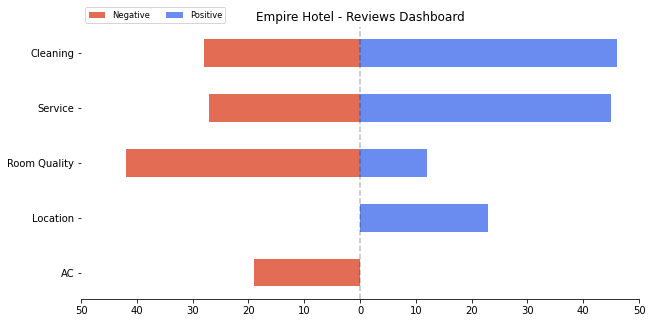

In [14]:
fig, ax = plot_dashboard(scores, category_names)
plt.show()

### Interested in learning more?
Take a look at our [blog post](https://www.ai21.com/blog/build-a-dashboard-based-on-freeform-sentiment-analysis-of-hotel-reviews) to understand the process of building a good prompt.

### E. Delete the endpoint

Now that you have successfully performed a real-time inference, you do not need the endpoint any more. You can terminate the endpoint to avoid being charged.

In [ ]:
model.sagemaker_session.delete_endpoint(model_name)
model.sagemaker_session.delete_endpoint_config(model_name)

## 4. Clean-up

### A. Delete the model

In [75]:
model.delete_model()